# AMEDA Eddy Centers Visualization

This notebook demonstrates the detection and visualization of oceanic eddy centers using the AMEDA algorithm.

## Features:
- Detection of eddy centers from velocity and SSH fields
- Interactive maps showing eddy locations
- Visualization of detection fields (LNAM, vorticity, OW)
- Statistical analysis of detected eddies

In [1]:
# Import required libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Circle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import AMEDA modules
import sys
sys.path.append('..')
from osl.ameda.params import AMEDAParams, derive_params
from osl.ameda.fields import compute_fields
from osl.ameda.load_fields import load_fields
from osl.ameda.eddy_centers import find_eddy_centers

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load and Prepare Data

In [2]:
# Configuration
DATASET_PATH = "/Users/gianlucacalo/Desktop/projects/ocean_surface_levels/data/raw/cmems_obs-sl_eur_phy-ssh_my_allsat-l4-duacs-0.0625deg_P1D.nc"
TIME_STEP = 0  # Which time step to analyze

# Check if dataset exists
if not Path(DATASET_PATH).exists():
    print(f"Dataset not found at {DATASET_PATH}")
    print("Please update DATASET_PATH to point to your NetCDF file")
else:
    # Load dataset
    ds = xr.open_dataset(DATASET_PATH)
    print(f"Dataset loaded: {ds.dims}")
    print(f"Variables: {list(ds.data_vars)}")
    print(f"Time range: {ds.time.values[0]} to {ds.time.values[-1]}")

Dataset loaded: FrozenMappingWarningOnValuesAccess({'time': 11487, 'latitude': 120, 'longitude': 321})
Variables: ['sla', 'ugos', 'vgos']
Time range: 1993-01-01T00:00:00.000000000 to 2024-06-13T00:00:00.000000000


In [3]:
# Set up AMEDA parameters
params = AMEDAParams(
    x_name="longitude",
    y_name="latitude",
    u_name="ugos",
    v_name="vgos",
    s_name="sla",
    type_detection=3,  # Use both velocity and SSH
    K=0.7,  # LNAM threshold
    nRmin=0.3,  # Minimum eddy size
    nR_lim=200,  # Maximum eddy size
    n_min=4,  # Minimum points for contour
    DH=0.001,  # SSH spacing for streamlines
    nH_lim=50,  # Maximum number of streamlines
    lat_min=5  # Minimum latitude for detection
)

print("Parameters configured")
print(f"Detection type: {'Velocity + SSH' if params.type_detection == 3 else 'Velocity only' if params.type_detection == 1 else 'SSH only'}")
print(f"LNAM threshold K: {params.K}")

Parameters configured
Detection type: Velocity + SSH
LNAM threshold K: 0.7


## 2. Run Eddy Detection

In [4]:
# Derive parameters from data
print("Deriving parameters...")
params = derive_params(ds, TIME_STEP, params)

# Load fields
print("Loading fields...")
x, y, mask, u, v, ssh = load_fields(ds, TIME_STEP, params)

# Compute detection fields
print("Computing detection fields...")
fields = compute_fields(x, y, mask, u, v, TIME_STEP, params)

# Find eddy centers
print("Finding eddy centers...")
centers = find_eddy_centers(x, y, mask, u, v, ssh, fields, params, TIME_STEP)

print(f"\nDetection complete!")
print(f"Raw LNAM maxima: {len(centers.centers0)}")
print(f"Validated centers: {len(centers.centers)}")

Deriving parameters...
Loading fields...
Loading fields at step 0...
NO INTERPOLATION
Enlarging coastal mask by 1 pixel...
Computing detection fields...
Computing fields for step 0
Computing LNAM...
Finding eddy centers...

 Find potential centers step 0 %-------------
  -> 75 max LNAM found step 0
  Remove max LNAM without 2 closed streamlines with proper size step 0
    Debug center 0 at (-29.22, 22.34): 253 streamlines, 65 closed, 1 with center, 1 valid radii
      Radii: [np.float64(76.3768861811852)] km, need 2.0 to 9855.3 km
    Debug center 1 at (-18.16, 22.41): 202 streamlines, 74 closed, 0 with center, 0 valid radii
   Validate max LNAM 2 with 2 streamlines at step 0
    Debug center 2 at (-21.03, 22.34): 235 streamlines, 9 closed, 2 with center, 2 valid radii
      Radii: [np.float64(14.646849855784009), np.float64(21.647028590481746)] km, need 2.0 to 9052.1 km
   Validate max LNAM 5 with 2 streamlines at step 0
   Validate max LNAM 6 with 2 streamlines at step 0
   Validate 

## 3. Visualize Detection Fields

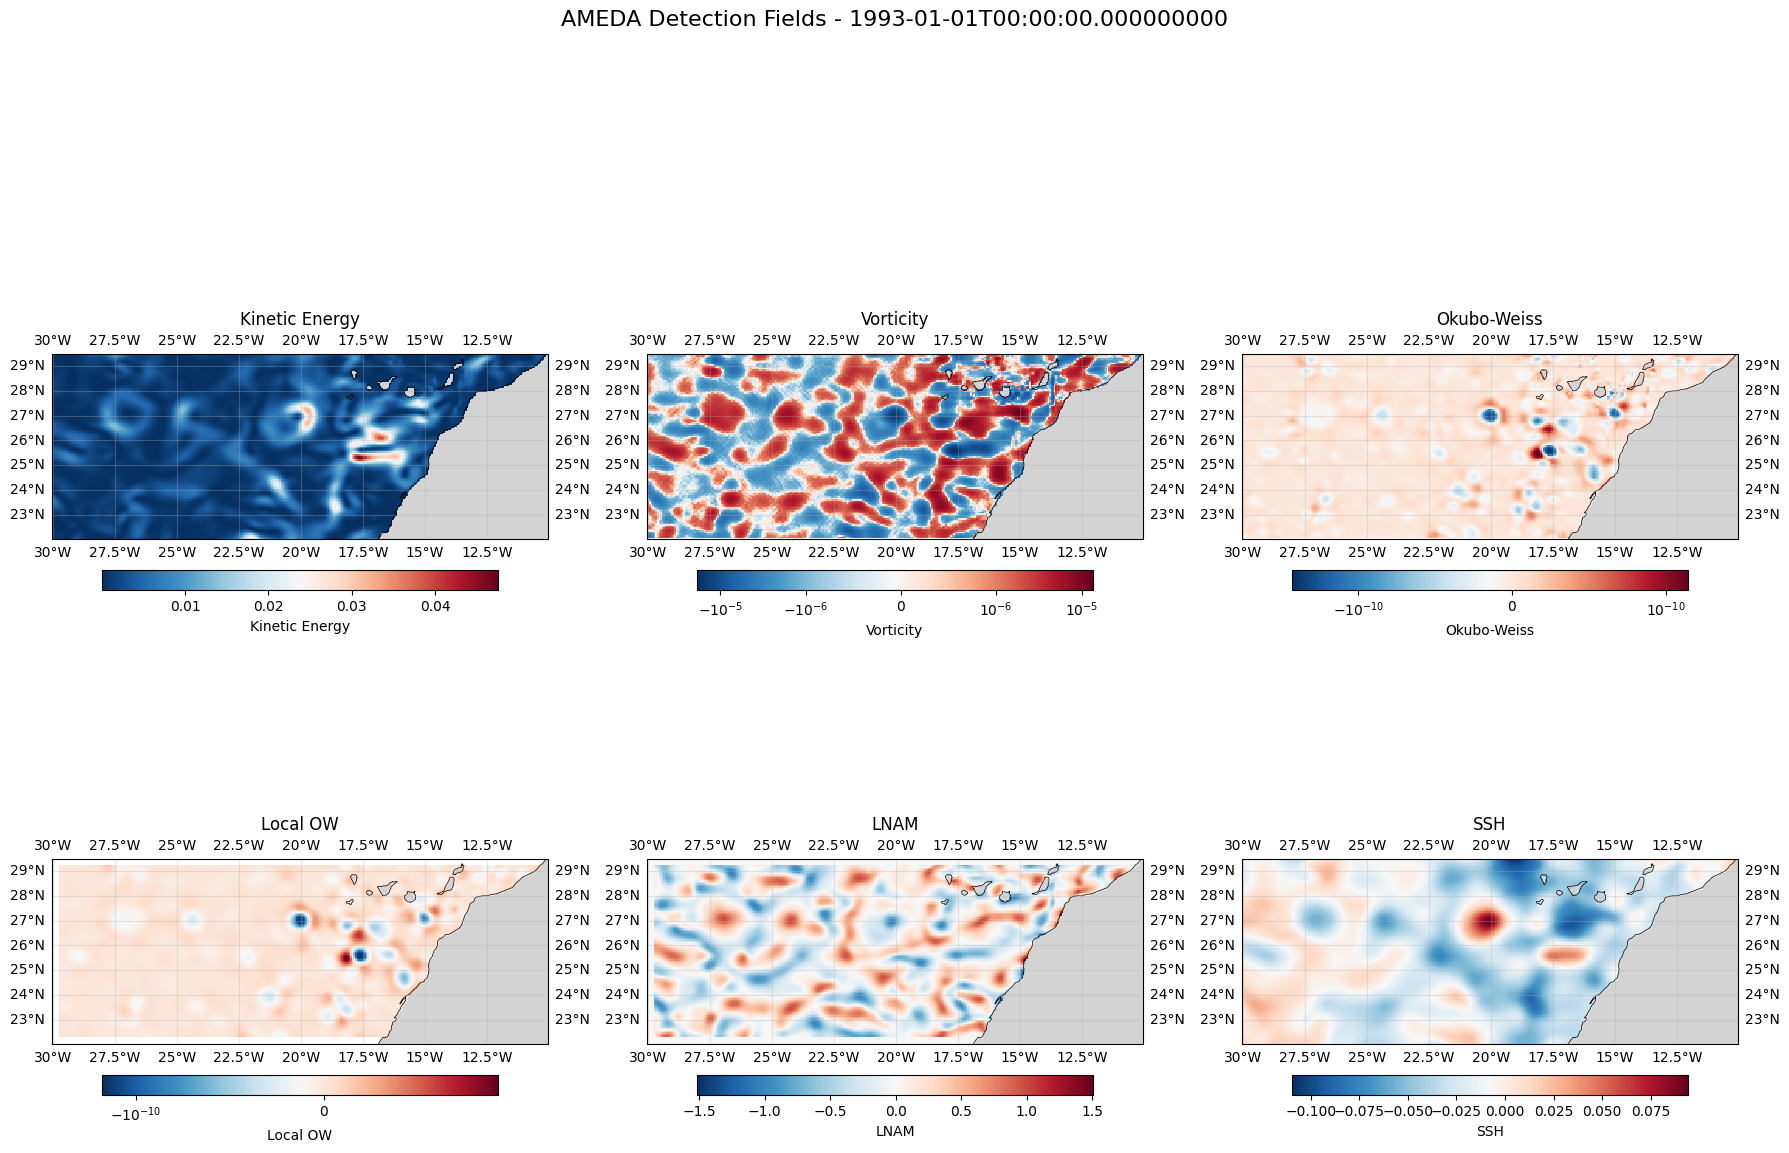

In [5]:
# Create figure with detection fields
fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(f'AMEDA Detection Fields - {ds.time.values[TIME_STEP]}', fontsize=16)

# Flatten axes for easier iteration
axes = axes.flatten()

# Define fields to plot
plot_fields = [
    (fields.ke * mask, 'Kinetic Energy', 'RdBu_r', None),
    (fields.vort * mask, 'Vorticity', 'RdBu_r', colors.SymLogNorm(linthresh=1e-6)),
    (fields.OW * mask, 'Okubo-Weiss', 'RdBu_r', colors.SymLogNorm(linthresh=1e-10)),
    (fields.LOW * mask, 'Local OW', 'RdBu_r', colors.SymLogNorm(linthresh=1e-10)),
    (fields.LNAM * mask, 'LNAM', 'RdBu_r', None),
    (ssh * mask if ssh is not None else np.zeros_like(mask), 'SSH', 'RdBu_r', None)
]

# Plot each field
for ax, (field, title, cmap, norm) in zip(axes, plot_fields):
    ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.gridlines(draw_labels=True, alpha=0.3)
    
    # Mask invalid values
    field_masked = np.ma.masked_where(mask == 0, field)
    
    # Plot field
    im = ax.pcolormesh(x, y, field_masked, cmap=cmap, norm=norm, 
                       transform=ccrs.PlateCarree(), shading='auto')
    
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar.set_label(title)
    ax.set_title(title)

plt.tight_layout()
plt.show()

## 4. Map of Detected Eddy Centers

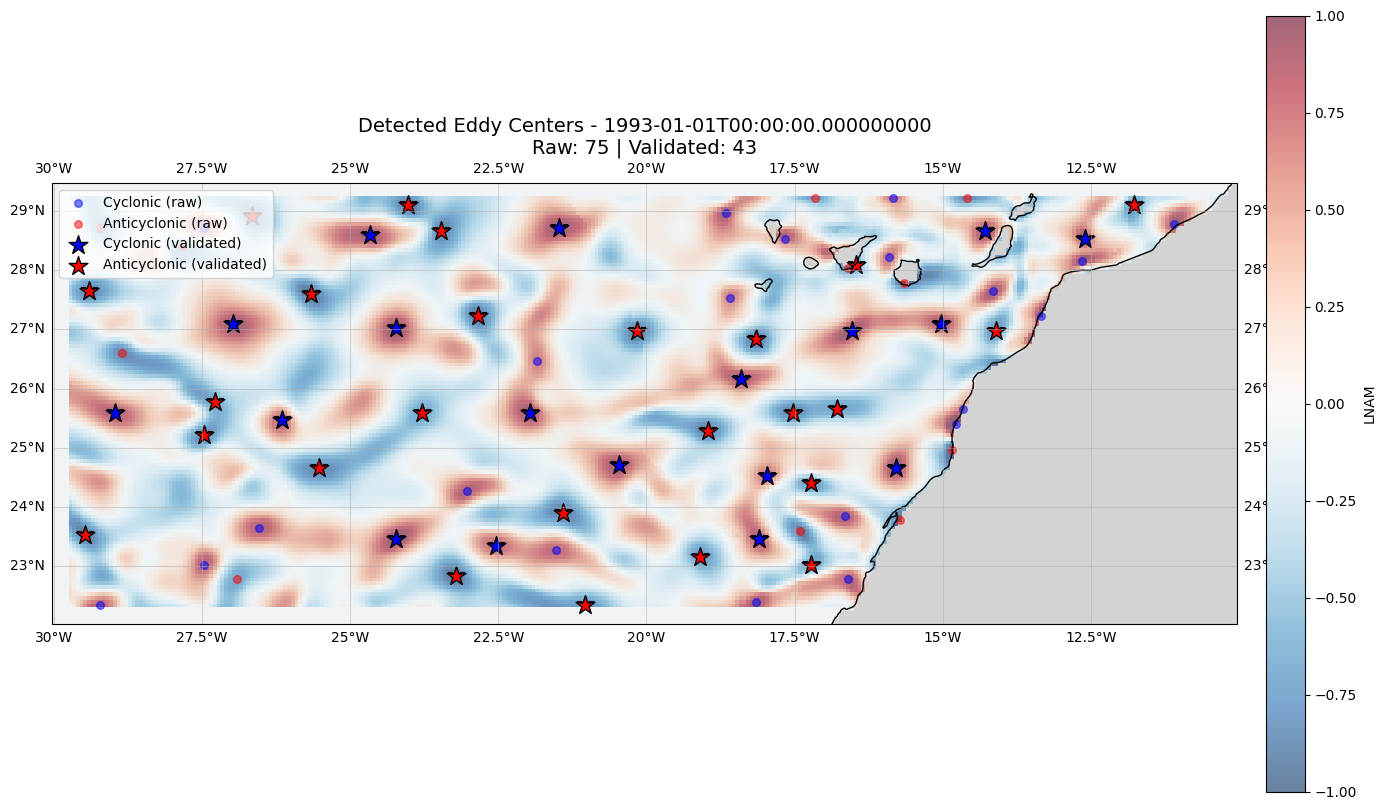

In [9]:
# Create map with detected centers
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)
ax.gridlines(draw_labels=True, alpha=0.5)

# Plot LNAM field as background
lnam_masked = np.ma.masked_where(mask == 0, fields.LNAM * mask)
im = ax.pcolormesh(x, y, lnam_masked, cmap='RdBu_r', alpha=0.6,
                   transform=ccrs.PlateCarree(), shading='auto',
                   vmin=-1, vmax=1)
plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, label='LNAM')

# Plot raw LNAM maxima
if len(centers.centers0) > 0:
    cyclonic = centers.centers0.type > 0
    anticyclonic = centers.centers0.type < 0
    
    ax.scatter(centers.centers0.x[cyclonic], centers.centers0.y[cyclonic],
               c='blue', marker='o', s=30, alpha=0.5,
               transform=ccrs.PlateCarree(), label='Cyclonic (raw)')
    ax.scatter(centers.centers0.x[anticyclonic], centers.centers0.y[anticyclonic],
               c='red', marker='o', s=30, alpha=0.5,
               transform=ccrs.PlateCarree(), label='Anticyclonic (raw)')

# Plot validated centers with larger markers
if len(centers.centers) > 0:
    cyclonic = centers.centers.type > 0
    anticyclonic = centers.centers.type < 0
    
    ax.scatter(centers.centers.x[cyclonic], centers.centers.y[cyclonic],
               c='blue', marker='*', s=200, edgecolors='black', linewidths=1,
               transform=ccrs.PlateCarree(), label='Cyclonic (validated)')
    ax.scatter(centers.centers.x[anticyclonic], centers.centers.y[anticyclonic],
               c='red', marker='*', s=200, edgecolors='black', linewidths=1,
               transform=ccrs.PlateCarree(), label='Anticyclonic (validated)')

# Add legend
ax.legend(loc='upper left', fontsize=10)

# Title
ax.set_title(f'Detected Eddy Centers - {ds.time.values[TIME_STEP]}\n'
            f'Raw: {len(centers.centers0)} | Validated: {len(centers.centers)}',
            fontsize=14)

plt.tight_layout()
plt.show()

## 5. Interactive Map with Plotly

In [10]:
# Create interactive map with Plotly
fig = go.Figure()

# Add velocity field as quiver
skip = 5  # Skip points for clarity
fig.add_trace(go.Scatter(
    x=x[::skip, ::skip].flatten(),
    y=y[::skip, ::skip].flatten(),
    mode='markers',
    marker=dict(size=2, color='gray', opacity=0.3),
    name='Grid points',
    showlegend=False
))

# Add raw LNAM maxima
if len(centers.centers0) > 0:
    # Cyclonic (raw)
    cyclonic = centers.centers0.type > 0
    fig.add_trace(go.Scatter(
        x=centers.centers0.x[cyclonic],
        y=centers.centers0.y[cyclonic],
        mode='markers',
        marker=dict(size=8, color='blue', opacity=0.4, symbol='circle'),
        name='Cyclonic (raw)',
        text=[f'Raw Cyclonic<br>Lon: {x:.2f}<br>Lat: {y:.2f}' 
              for x, y in zip(centers.centers0.x[cyclonic], centers.centers0.y[cyclonic])],
        hoverinfo='text'
    ))
    
    # Anticyclonic (raw)
    anticyclonic = centers.centers0.type < 0
    fig.add_trace(go.Scatter(
        x=centers.centers0.x[anticyclonic],
        y=centers.centers0.y[anticyclonic],
        mode='markers',
        marker=dict(size=8, color='red', opacity=0.4, symbol='circle'),
        name='Anticyclonic (raw)',
        text=[f'Raw Anticyclonic<br>Lon: {x:.2f}<br>Lat: {y:.2f}' 
              for x, y in zip(centers.centers0.x[anticyclonic], centers.centers0.y[anticyclonic])],
        hoverinfo='text'
    ))

# Add validated centers
if len(centers.centers) > 0:
    # Cyclonic (validated)
    cyclonic = centers.centers.type > 0
    fig.add_trace(go.Scatter(
        x=centers.centers.x[cyclonic],
        y=centers.centers.y[cyclonic],
        mode='markers',
        marker=dict(size=15, color='blue', symbol='star',
                   line=dict(color='black', width=1)),
        name='Cyclonic (validated)',
        text=[f'Validated Cyclonic<br>Lon: {x:.2f}<br>Lat: {y:.2f}<br>Index: {i}' 
              for i, (x, y) in enumerate(zip(centers.centers.x[cyclonic], centers.centers.y[cyclonic]))],
        hoverinfo='text'
    ))
    
    # Anticyclonic (validated) 
    anticyclonic = centers.centers.type < 0
    fig.add_trace(go.Scatter(
        x=centers.centers.x[anticyclonic],
        y=centers.centers.y[anticyclonic],
        mode='markers',
        marker=dict(size=15, color='red', symbol='star',
                   line=dict(color='black', width=1)),
        name='Anticyclonic (validated)',
        text=[f'Validated Anticyclonic<br>Lon: {x:.2f}<br>Lat: {y:.2f}<br>Index: {i}' 
              for i, (x, y) in enumerate(zip(centers.centers.x[anticyclonic], centers.centers.y[anticyclonic]))],
        hoverinfo='text'
    ))

# Update layout
fig.update_layout(
    title=f'Interactive Eddy Centers Map - {ds.time.values[TIME_STEP]}',
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    hovermode='closest',
    width=1000,
    height=700,
    showlegend=True,
    legend=dict(x=0.02, y=0.98)
)

# Set equal aspect ratio
fig.update_xaxes(scaleanchor="y", scaleratio=1)

fig.show()

## 6. Statistical Analysis

EDDY DETECTION STATISTICS

Time: 1993-01-01T00:00:00.000000000
Domain: Lon [-30.03, -10.03], Lat [22.03, 29.47]

Detection Results:
  Raw LNAM maxima: 75
  Validated centers: 43
  Validation rate: 57.3%

Eddy Types:
  Cyclonic: 18 (41.9%)
  Anticyclonic: 25 (58.1%)

Spatial Distribution:
  Longitude range: [-29.47, -11.78]
  Latitude range: [22.34, 29.09]
  Mean position: (-21.14, 25.99)


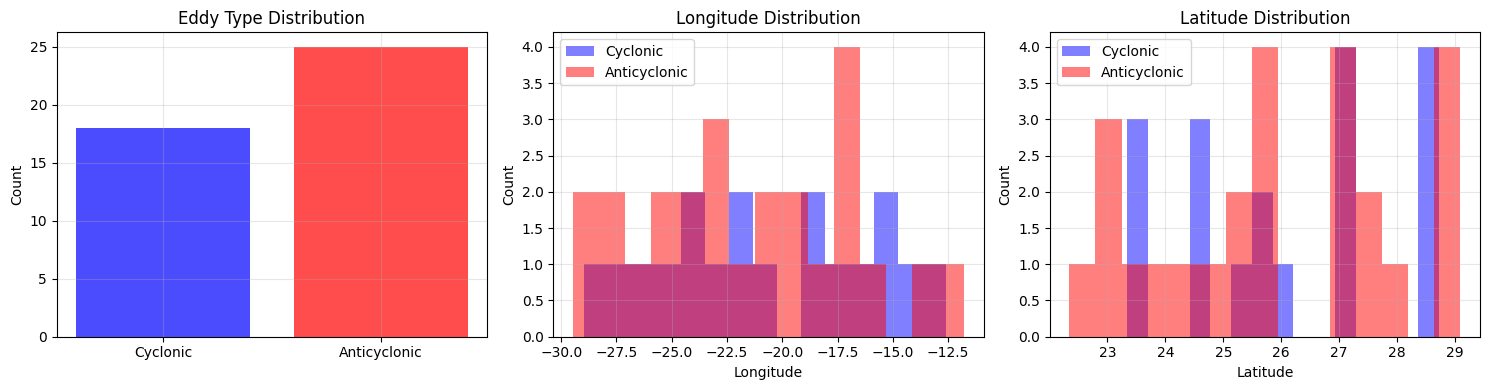

In [12]:
# Analyze detected eddies
if len(centers.centers) > 0:
    n_cyclonic = np.sum(centers.centers.type > 0)
    n_anticyclonic = np.sum(centers.centers.type < 0)
    
    print("=" * 50)
    print("EDDY DETECTION STATISTICS")
    print("=" * 50)
    print(f"\nTime: {ds.time.values[TIME_STEP]}")
    print(f"Domain: Lon [{x.min():.2f}, {x.max():.2f}], Lat [{y.min():.2f}, {y.max():.2f}]")
    
    print(f"\nDetection Results:")
    print(f"  Raw LNAM maxima: {len(centers.centers0)}")
    print(f"  Validated centers: {len(centers.centers)}")
    print(f"  Validation rate: {100*len(centers.centers)/len(centers.centers0):.1f}%")
    
    print(f"\nEddy Types:")
    print(f"  Cyclonic: {n_cyclonic} ({100*n_cyclonic/len(centers.centers):.1f}%)")
    print(f"  Anticyclonic: {n_anticyclonic} ({100*n_anticyclonic/len(centers.centers):.1f}%)")
    
    # Spatial distribution
    print(f"\nSpatial Distribution:")
    print(f"  Longitude range: [{centers.centers.x.min():.2f}, {centers.centers.x.max():.2f}]")
    print(f"  Latitude range: [{centers.centers.y.min():.2f}, {centers.centers.y.max():.2f}]")
    print(f"  Mean position: ({centers.centers.x.mean():.2f}, {centers.centers.y.mean():.2f})")
    
    # Create distribution plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Histogram of eddy types
    axes[0].bar(['Cyclonic', 'Anticyclonic'], [n_cyclonic, n_anticyclonic], 
                color=['blue', 'red'], alpha=0.7)
    axes[0].set_ylabel('Count')
    axes[0].set_title('Eddy Type Distribution')
    axes[0].grid(alpha=0.3)
    
    # Longitude distribution
    axes[1].hist(centers.centers.x[centers.centers.type > 0], bins=15, 
                 alpha=0.5, color='blue', label='Cyclonic')
    axes[1].hist(centers.centers.x[centers.centers.type < 0], bins=15, 
                 alpha=0.5, color='red', label='Anticyclonic')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Longitude Distribution')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # Latitude distribution
    axes[2].hist(centers.centers.y[centers.centers.type > 0], bins=15, 
                 alpha=0.5, color='blue', label='Cyclonic')
    axes[2].hist(centers.centers.y[centers.centers.type < 0], bins=15, 
                 alpha=0.5, color='red', label='Anticyclonic')
    axes[2].set_xlabel('Latitude')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Latitude Distribution')
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No validated eddy centers detected.")
    print("Try adjusting the detection parameters (K, nRmin, etc.)")